# ***Image De-noising Using Deep Learning***


Denoising an image is a classical problem that researchers are trying to solve for decades. In earlier times, researchers used filters to reduce the noise in the images. They used to work fairly well for images with a reasonable level of noise. However, applying those filters would add a blur to the image. And if the image is too noisy, then the resultant image would be so blurry that most of the critical details in the image are lost.


There has to be a better way to solve this problem. As a result, I have implemented several deep learning architectures that far surpass the traditional denoising filters. In this blog, I will explain my approach step-by-step as a case study, starting from the problem formulation to implementing the state-of-the-art deep learning models, and then finally see the results.

So what we will focused on:
- What is noise in images?
- Source of Data
- Exploratory Data Analysis
- An Overview on Traditional Filters for Image Denoising
- Deep Learning Models for Image Denoising
- Results Comparison


---
- What is noise in images?
  - Image noise is a random variation of brightness or color information in the images captured. It is degradation in image signal caused by external sources. Mathematically, noise in an image can be represented by <br>**A(x,y) = B(x,y) + H(x,y)**<br>
    Where,<br>
    A(x,y)= function of noisy image;<br>
    B(x,y)= function of original image;<br>
    H(x,y)= function of noise;

---
- Source of Data<br>
`For the limitation of GPU using only SIDD Dataset`
  1. SIDD: https://www.eecs.yorku.ca/~kamel/sidd/dataset.php 
  2. RENOIR: https://adrianbarburesearch.blogspot.com/p/renoir-dataset.html
  3. NIND: https://commons.wikimedia.org/wiki/Natural_Image_Noise_Dataset#Tools


---





In [6]:
# Import Libraries

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import os
import pathlib
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
import cv2

from tqdm.notebook import tqdm #https://tqdm.github.io/docs/notebook/
import random


In [10]:
#Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:

# Extract zip files to a destination directory,
# https://askubuntu.com/a/1049564
if 'SIDD_Small_sRGB_Only' not in os.listdir():
    !gdown https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
    get_ipython().system_raw('7z x SIDD_Small_sRGB_Only.zip -o/content/ && rm SIDD_Small_sRGB_Only.zip')

Downloading...
From: https://drive.google.com/uc?id=1uhBXtYT2BZEbHEShTBw4KKOjj3SUnHrD
To: /content/SIDD_Small_sRGB_Only.zip
6.62GB [02:14, 49.3MB/s]


In [7]:
def create_paths_df(root_dir):
    root = pathlib.Path(root_dir)
    img_paths = list(root.rglob("*.PNG*"))
    img_paths_lst = [str(path) for path in img_paths]

    noisy_lst = []
    gt_lst = []
    for p in img_paths_lst:
        img_type = p.split("/")[-1].split('_')[-3]
        if img_type=="NOISY":
            noisy_lst.append(p)
        elif img_type=="GT":
            gt_lst.append(p)
    paths_df = pd.DataFrame(list(zip(noisy_lst, gt_lst)), columns =['Noisy_paths', 'GT_paths'])
    return paths_df

In [8]:
paths_df = create_paths_df("SIDD_Small_sRGB_Only")
paths_df.head()

,Noisy_paths,GT_paths
0,SIDD_Small_sRGB_Only/Data/0057_003_G4_00100_00...,SIDD_Small_sRGB_Only/Data/0057_003_G4_00100_00...
1,SIDD_Small_sRGB_Only/Data/0127_006_S6_01600_00...,SIDD_Small_sRGB_Only/Data/0127_006_S6_01600_00...
2,SIDD_Small_sRGB_Only/Data/0027_001_G4_00800_00...,SIDD_Small_sRGB_Only/Data/0027_001_G4_00800_00...
3,SIDD_Small_sRGB_Only/Data/0036_002_GP_06400_03...,SIDD_Small_sRGB_Only/Data/0036_002_GP_06400_03...
4,SIDD_Small_sRGB_Only/Data/0160_007_IP_00400_00...,SIDD_Small_sRGB_Only/Data/0160_007_IP_00400_00...


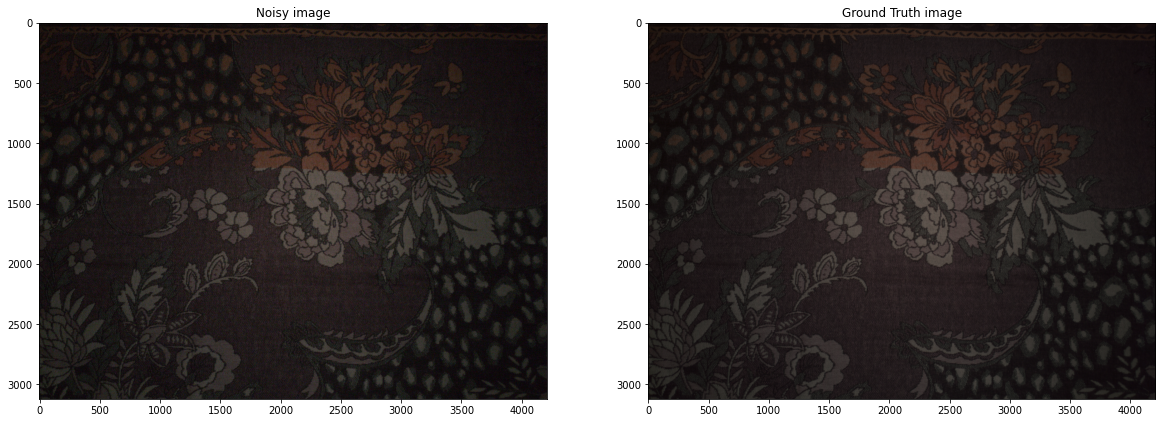

In [24]:
# Randomly displaying an image pair
rand_image_idx = random.choice(range(160))

noisy_img = cv2.imread(paths_df['Noisy_paths'][rand_image_idx])
gt_img = cv2.imread(paths_df['GT_paths'][rand_image_idx])

noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

f, axarr = plt.subplots(1,2, figsize=(20,20))
axarr[0].imshow(noisy_img)
axarr[0].title.set_text("Noisy image")

axarr[1].imshow(gt_img)
axarr[1].title.set_text("Ground Truth image")

Google Pixel =>	 20.62 %
IPhone 7 =>	 33.75 %
Samsung S6 =>	 21.88 %
LG G4 =>	 10.0 %
Motorola Nexus 6 => 13.75 %



<BarContainer object of 5 artists>

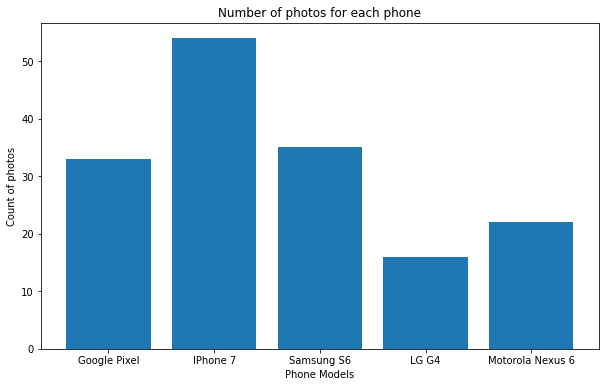

In [27]:
#Analysis
#number of photos from each phone
GP_count=0
IP_count=0
S6_count=0
G4_count=0
N6_count=0

noisy_paths = paths_df['Noisy_paths'].values
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    if "GP" == phone_model:
        GP_count+=1
    if "IP" == phone_model:
        IP_count+=1
    if "S6" == phone_model:
        S6_count+=1
    if "G4" == phone_model:
        G4_count+=1
    if "N6" == phone_model:
        N6_count+=1
total = GP_count+IP_count+S6_count+G4_count+N6_count
print("Google Pixel =>\t",round(GP_count/total*100,2),"%")
print("IPhone 7 =>\t",round(IP_count/total*100,2),"%")
print("Samsung S6 =>\t",round(S6_count/total*100,2),"%")
print("LG G4 =>\t",round(G4_count/total*100,2),"%")
print("Motorola Nexus 6 =>",round(N6_count/total*100,2),"%")
print()

plt.figure(figsize=(10,6))
plt.xlabel("Phone Models") 
plt.ylabel("Count of photos")
plt.title("Number of photos for each phone")
plt.bar(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"], [GP_count, IP_count, S6_count, G4_count, N6_count])

In [28]:
# Get unique ISO Level 
noisy_paths = paths_df['Noisy_paths'].values
unique_iso_levels = set()
for p  in noisy_paths:
  iso_level = p.split("/")[2].split("_")[3]
  unique_iso_levels.add(iso_level)
print("Unique ISO levels used:")
print(unique_iso_levels)

Unique ISO levels used:
{'00100', '03200', '00050', '00400', '00800', '02000', '01000', '00200', '00500', '01600', '00320', '00640', '06400', '10000'}


In [29]:
def visualize_heatmap(df, title, x_label, heat_strip_label="Number of photos", annot_=True):
    plt.figure(figsize=(18,10))
    ax = sns.heatmap(
        df,
        cmap="Blues",
        annot=annot_,
        cbar_kws={'label': heat_strip_label, 'orientation': 'vertical'},
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel("Phones")
    plt.title(title)

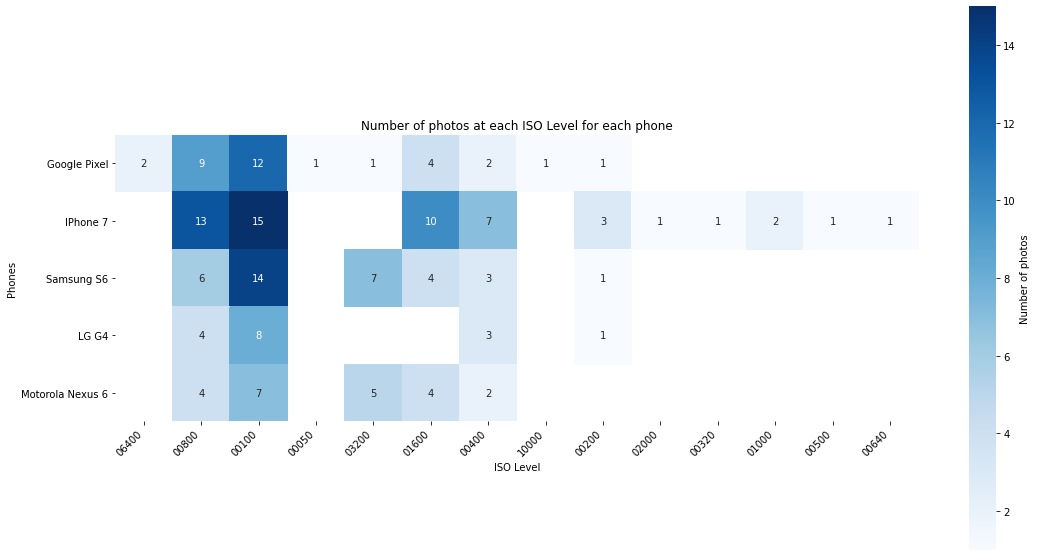

In [30]:
# Number of photos from each ISO level
GP_count={}
IP_count={}
S6_count={}
G4_count={}
N6_count={}

noisy_paths = paths_df['Noisy_paths'].values  
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    iso_level = p.split("/")[2].split("_")[3]
    if "GP" == phone_model:
        iso_exists = GP_count.get(iso_level)
        if iso_exists == None:
            GP_count[iso_level]=1
        else:
            GP_count[iso_level]+=1
    if "IP" == phone_model:
        iso_exists = IP_count.get(iso_level)
        if iso_exists == None:
            IP_count[iso_level]=1
        else:
            IP_count[iso_level]+=1
    if "S6" == phone_model:
        iso_exists = S6_count.get(iso_level)
        if iso_exists == None:
            S6_count[iso_level]=1
        else:
            S6_count[iso_level]+=1
    if "G4" == phone_model:
        iso_exists = G4_count.get(iso_level)
        if iso_exists == None:
            G4_count[iso_level]=1
        else:
            G4_count[iso_level]+=1
    if "N6" == phone_model:
        iso_exists = N6_count.get(iso_level)
        if iso_exists == None:
            N6_count[iso_level]=1
        else:
            N6_count[iso_level]+=1

noise_level_df = pd.DataFrame([GP_count, IP_count, S6_count, G4_count, N6_count]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
visualize_heatmap(noise_level_df, "Number of photos at each ISO Level for each phone", "ISO Level")

In [32]:
# Get unique Shutter speeds used in the dataset
noisy_paths = paths_df['Noisy_paths'].values   
unique_shutter_speeds = set()
for p in noisy_paths:
    shutter_speed = p.split("/")[2].split("_")[4]
    unique_shutter_speeds.add(shutter_speed)
print("Unique Shutter speeds used:")
print(unique_shutter_speeds)

Unique Shutter speeds used:
{'00060', '00400', '00125', '01600', '00160', '00080', '00350', '00800', '00025', '04160', '08460', '03100', '00100', '00050', '01000', '02000', '00250', '00500', '00640', '04000', '00180', '03200', '00200', '00020', '00320', '01520', '01250', '06400', '00750', '02500'}


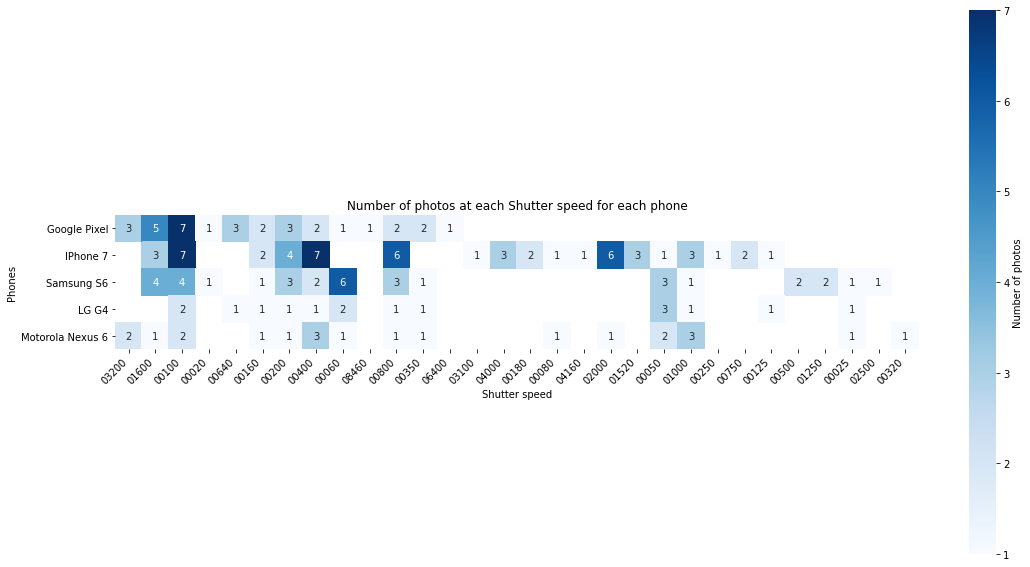

In [33]:
# Number of photos for every Shutter speed
GP_count={}
IP_count={}
S6_count={}
G4_count={}
N6_count={}

noisy_paths = paths_df['Noisy_paths'].values    # We could have taken GT paths also. After all, the images are in pairs!
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    shutter_speed = p.split("/")[2].split("_")[4]
    if "GP" == phone_model:
        shutter_exist = GP_count.get(shutter_speed)
        if shutter_exist == None:
            GP_count[shutter_speed]=1
        else:
            GP_count[shutter_speed]+=1
    if "IP" == phone_model:
        shutter_exist = IP_count.get(shutter_speed)
        if shutter_exist == None:
            IP_count[shutter_speed]=1
        else:
            IP_count[shutter_speed]+=1
    if "S6" == phone_model:
        shutter_exist = S6_count.get(shutter_speed)
        if shutter_exist == None:
            S6_count[shutter_speed]=1
        else:
            S6_count[shutter_speed]+=1
    if "G4" == phone_model:
        shutter_exist = G4_count.get(shutter_speed)
        if shutter_exist == None:
            G4_count[shutter_speed]=1
        else:
            G4_count[shutter_speed]+=1
    if "N6" == phone_model:
        shutter_exist = N6_count.get(shutter_speed)
        if shutter_exist == None:
            N6_count[shutter_speed]=1
        else:
            N6_count[shutter_speed]+=1

shutter_speed_df = pd.DataFrame([GP_count, IP_count, S6_count, G4_count, N6_count]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
visualize_heatmap(shutter_speed_df, "Number of photos at each Shutter speed for each phone", "Shutter speed")

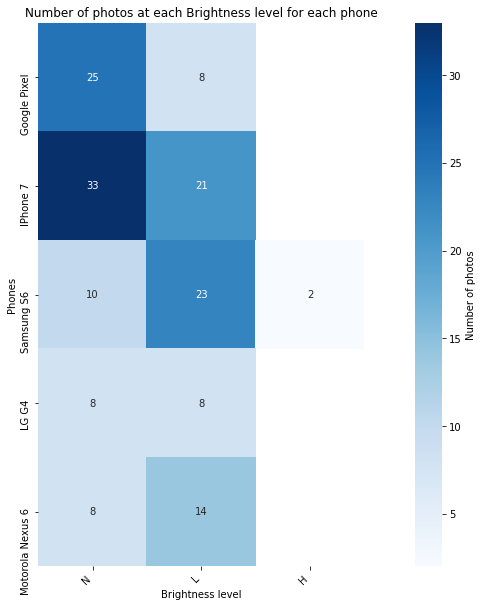

In [35]:
# Number of photos for every Brightness level
GP_count={}
IP_count={}
S6_count={}
G4_count={}
N6_count={}

noisy_paths = paths_df['Noisy_paths'].values
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    brightness_level = p.split("/")[2][-1]
    if "GP" == phone_model:
        bright_exists = GP_count.get(brightness_level)
        if bright_exists == None:
            GP_count[brightness_level]=1
        else:
            GP_count[brightness_level]+=1
    if "IP" == phone_model:
        bright_exists = IP_count.get(brightness_level)
        if bright_exists == None:
            IP_count[brightness_level]=1
        else:
            IP_count[brightness_level]+=1
    if "S6" == phone_model:
        bright_exists = S6_count.get(brightness_level)
        if bright_exists == None:
            S6_count[brightness_level]=1
        else:
            S6_count[brightness_level]+=1
    if "G4" == phone_model:
        bright_exists = G4_count.get(brightness_level)
        if bright_exists == None:
            G4_count[brightness_level]=1
        else:
            G4_count[brightness_level]+=1
    if "N6" == phone_model:
        bright_exists = N6_count.get(brightness_level)
        if bright_exists == None:
            N6_count[brightness_level]=1
        else:
            N6_count[brightness_level]+=1

brightness_level_df = pd.DataFrame([GP_count, IP_count, S6_count, G4_count, N6_count]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
visualize_heatmap(brightness_level_df, "Number of photos at each Brightness level for each phone", "Brightness level")

In [36]:
# Resolution of image

GP_res={}
IP_res={}
S6_res={}
G4_res={}
N6_res={}

noisy_paths = paths_df['Noisy_paths'].values
for p in noisy_paths:
    phone_model = p.split("/")[2].split("_")[2]
    noisy_img = cv2.imread(p)
    img_resolution = str(noisy_img.shape[0:2])
    if "GP" == phone_model:
        res_exists = GP_res.get(img_resolution)
        if res_exists == None:
            GP_res[img_resolution]=1
        else:
            GP_res[img_resolution]+=1
    if "IP" == phone_model:
        res_exists = IP_res.get(img_resolution)
        if res_exists == None:
            IP_res[img_resolution]=1
        else:
            IP_res[img_resolution]+=1
    if "S6" == phone_model:
        res_exists = S6_res.get(img_resolution)
        if res_exists == None:
            S6_res[img_resolution]=1
        else:
            S6_res[img_resolution]+=1
    if "G4" == phone_model:
        res_exists = G4_res.get(img_resolution)
        if res_exists == None:
            G4_res[img_resolution]=1
        else:
            G4_res[img_resolution]+=1
    if "N6" == phone_model:
        res_exists = N6_res.get(img_resolution)
        if res_exists == None:
            N6_res[img_resolution]=1
        else:
            N6_res[img_resolution]+=1

In [37]:
res_df = pd.DataFrame([GP_res, IP_res, S6_res, G4_res, N6_res]).rename(pd.Series(["Google Pixel", "IPhone 7", "Samsung S6", "LG G4", "Motorola Nexus 6"]))
res_df.head()

,"(3044, 4048)","(3024, 4032)","(3000, 5328)","(2988, 5312)","(3120, 4208)"
Google Pixel,33.0,NaN,NaN,NaN,NaN
IPhone 7,NaN,54.0,NaN,NaN,NaN
Samsung S6,NaN,NaN,35.0,NaN,NaN
LG G4,NaN,NaN,NaN,16.0,NaN
Motorola Nexus 6,NaN,NaN,NaN,NaN,22.0



**Analysis on the Image data**

In [38]:
noisy_paths = paths_df['Noisy_paths'].values

noisy_red_means = []
noisy_green_means = []
noisy_blue_means = []

noisy_red_std_dev = []
noisy_green_std_dev = []
noisy_blue_std_dev = []

for p in noisy_paths:
    noisy_img = cv2.imread(p)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)

    red_channel_pixels = noisy_img[:,:,0]
    noisy_red_means.append(np.mean(red_channel_pixels))
    noisy_red_std_dev.append(np.std(red_channel_pixels))

    green_channel_pixels = noisy_img[:,:,1]
    noisy_green_means.append(np.mean(green_channel_pixels))
    noisy_green_std_dev.append(np.std(green_channel_pixels))

    blue_channel_pixels = noisy_img[:,:,2]
    noisy_blue_means.append(np.mean(blue_channel_pixels))
    noisy_blue_std_dev.append(np.std(blue_channel_pixels))

In [39]:
gt_paths = paths_df['GT_paths'].values

gt_red_means = []
gt_green_means = []
gt_blue_means = []

gt_red_std_dev = []
gt_green_std_dev = []
gt_blue_std_dev = []

for p in gt_paths:
    gt_img = cv2.imread(p)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

    red_channel_pixels = gt_img[:,:,0]
    gt_red_means.append(np.mean(red_channel_pixels))
    gt_red_std_dev.append(np.std(red_channel_pixels))

    green_channel_pixels = gt_img[:,:,1]
    gt_green_means.append(np.mean(green_channel_pixels))
    gt_green_std_dev.append(np.std(green_channel_pixels))

    blue_channel_pixels = gt_img[:,:,2]
    gt_blue_means.append(np.mean(blue_channel_pixels))
    gt_blue_std_dev.append(np.std(blue_channel_pixels))

Text(0.5, 0, 'Mean')

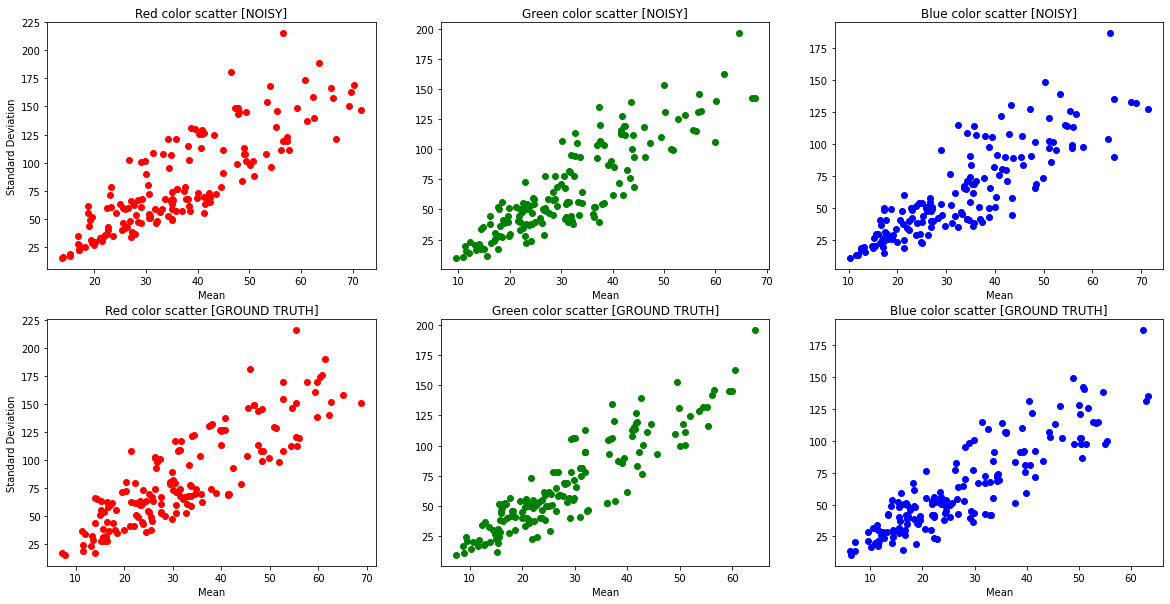

In [40]:
f, ax = plt.subplots(2,3, figsize=(20,10))
ax[0][0].scatter(noisy_red_std_dev, noisy_red_means, color='r')
ax[0][0].title.set_text("Red color scatter [NOISY]")
ax[0][0].set_xlabel("Mean")
ax[0][0].set_ylabel("Standard Deviation")

ax[0][1].scatter(noisy_green_std_dev, noisy_green_means, color='g')
ax[0][1].title.set_text("Green color scatter [NOISY]")
ax[0][1].set_xlabel("Mean")

ax[0][2].scatter(noisy_blue_std_dev, noisy_blue_means, color='b')
ax[0][2].title.set_text("Blue color scatter [NOISY]")
ax[0][2].set_xlabel("Mean")
#-----------------------------
ax[1][0].scatter(gt_red_std_dev, gt_red_means, color='r')
ax[1][0].title.set_text("Red color scatter [GROUND TRUTH]")
ax[1][0].set_xlabel("Mean")
ax[1][0].set_ylabel("Standard Deviation")

ax[1][1].scatter(gt_green_std_dev, gt_green_means, color='g')
ax[1][1].title.set_text("Green color scatter [GROUND TRUTH]")
ax[1][1].set_xlabel("Mean")

ax[1][2].scatter(gt_blue_std_dev, gt_blue_means, color='b')
ax[1][2].title.set_text("Blue color scatter [GROUND TRUTH]")
ax[1][2].set_xlabel("Mean")

Text(0.5, 1.0, 'Noisy images pixel intensity distribution')

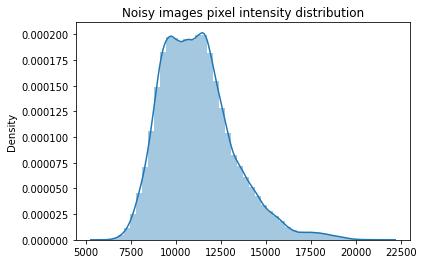

In [41]:
noisy_paths = paths_df['Noisy_paths'].values
noisy_flattened_imgs = []
for p in noisy_paths:
    noisy_img = cv2.imread(p)
    noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
    noisy_img = cv2.resize(noisy_img, (2900, 4000),  interpolation = cv2.INTER_NEAREST)
    noisy_flattened_imgs.append(np.ravel(noisy_img))

falttened_sum_noisy = np.sum(np.array(noisy_flattened_imgs), axis=0)  # This will sum the pixel values of each pixel [each pixels is as column, each row is an image]

ax = sns.distplot(falttened_sum_noisy)
ax.set_title('Noisy images pixel intensity distribution')

Text(0.5, 1.0, 'Ground truth images pixel intensity distribution')

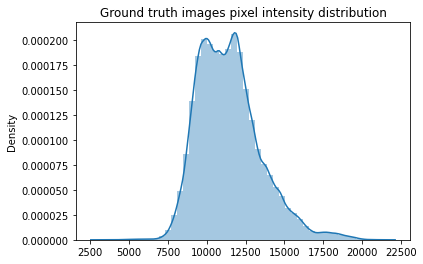

In [9]:
gt_paths = paths_df['GT_paths'].values
gt_flattened_imgs = []
for p in gt_paths:
    gt_img = cv2.imread(p)
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    gt_img = cv2.resize(gt_img, (2900, 4000),  interpolation = cv2.INTER_NEAREST)
    gt_flattened_imgs.append(np.ravel(gt_img))

falttened_sum_gt = np.sum(np.array(gt_flattened_imgs), axis=0)  # This will sum the pixel values of each pixel [each pixels is as column, each row is an image]

ax = sns.distplot(falttened_sum_gt)
ax.set_title('Ground truth images pixel intensity distribution')

In [10]:
#Histogram plotting
def get_histogram(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    histr_r = cv2.calcHist([img],[0],None,[256],[0,256])
    histr_g = cv2.calcHist([img],[1],None,[256],[0,256])
    histr_b = cv2.calcHist([img],[2],None,[256],[0,256])
    return histr_r, histr_g, histr_b, img

Text(0.5, 1.0, 'Ground truth image histogram')

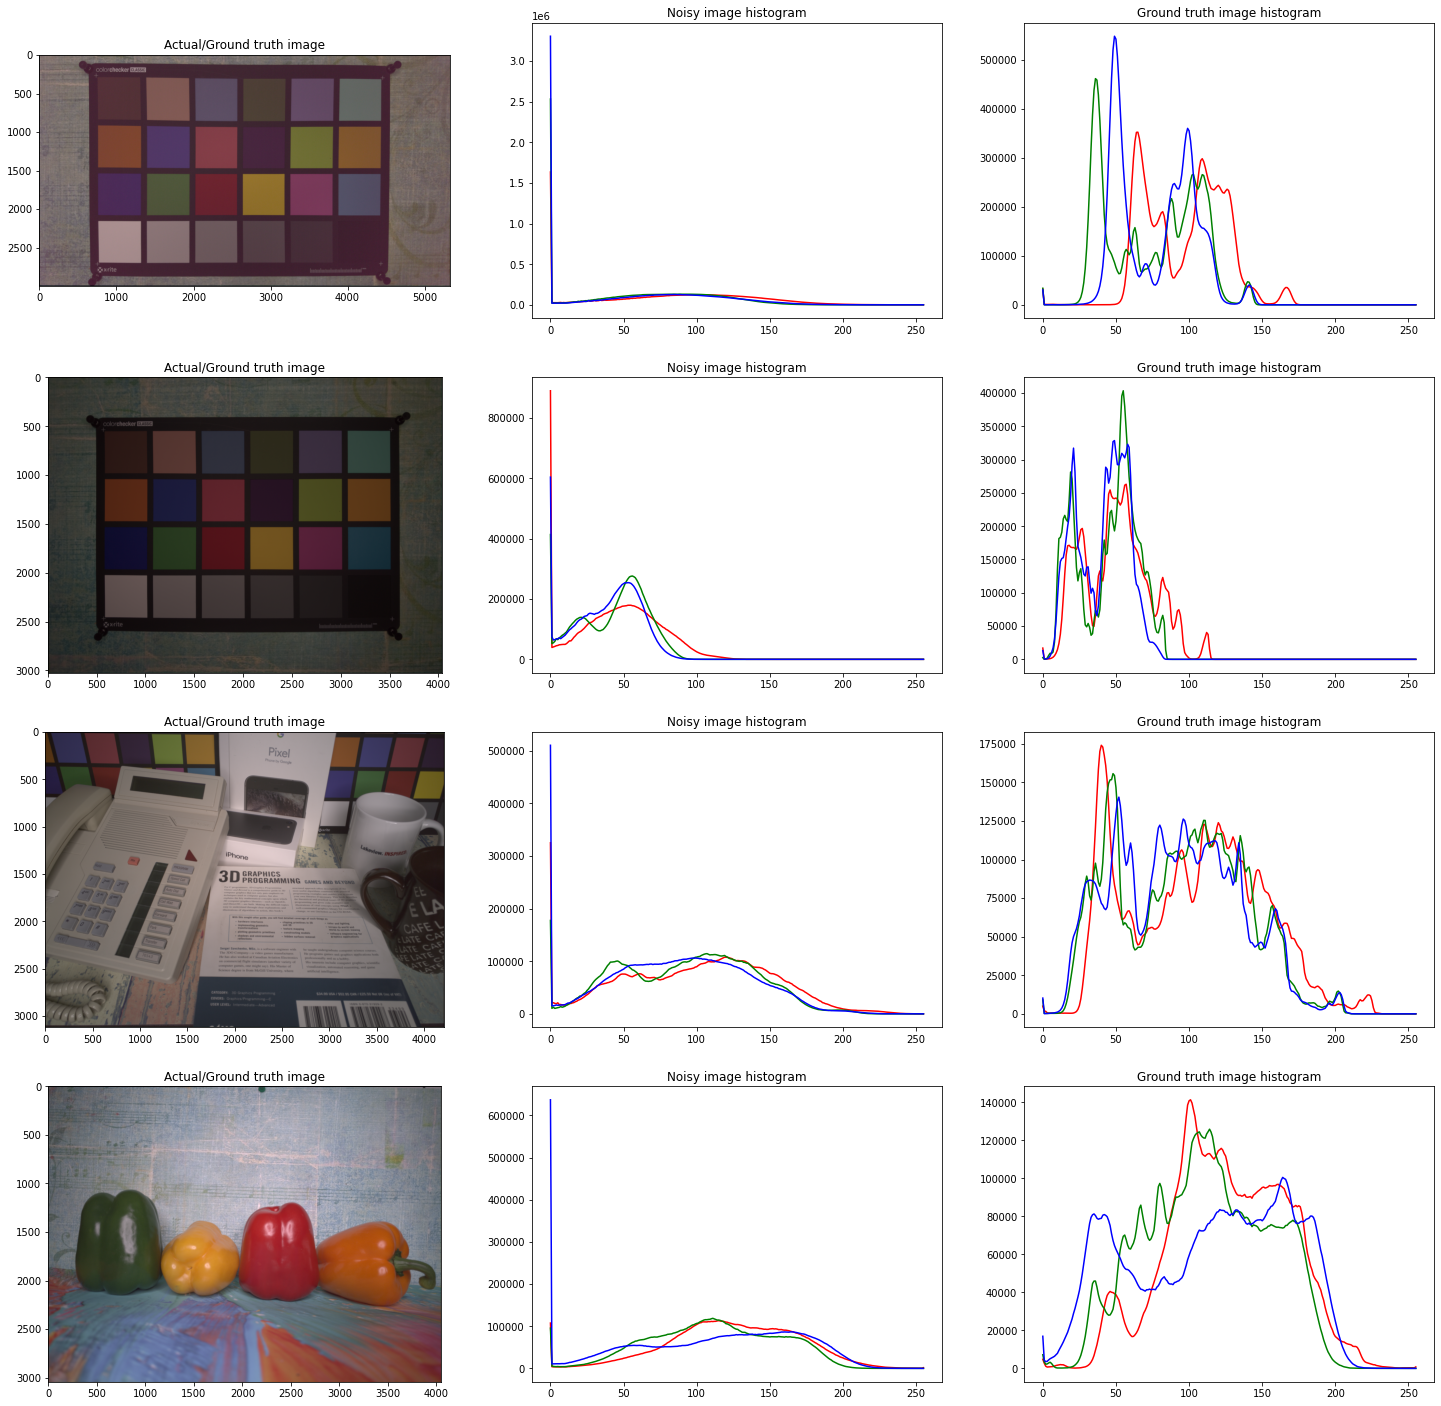

In [11]:
f,ax = plt.subplots(4,3, figsize=(25,25))

rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[0][1].plot(histr_r, color="r")
ax[0][1].plot(histr_g, color='g')
ax[0][1].plot(histr_b, color='b')
ax[0][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[0][0].imshow(img)
ax[0][0].set_title("Actual/Ground truth image")

ax[0][2].plot(histr_r, color="r")
ax[0][2].plot(histr_g, color='g')
ax[0][2].plot(histr_b, color='b')
ax[0][2].set_title("Ground truth image histogram")

#------------
rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[1][1].plot(histr_r, color="r")
ax[1][1].plot(histr_g, color='g')
ax[1][1].plot(histr_b, color='b')
ax[1][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[1][0].imshow(img)
ax[1][0].set_title("Actual/Ground truth image")

ax[1][2].plot(histr_r, color="r")
ax[1][2].plot(histr_g, color='g')
ax[1][2].plot(histr_b, color='b')
ax[1][2].set_title("Ground truth image histogram")

#------------
rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[2][1].plot(histr_r, color="r")
ax[2][1].plot(histr_g, color='g')
ax[2][1].plot(histr_b, color='b')
ax[2][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[2][0].imshow(img)
ax[2][0].set_title("Actual/Ground truth image")

ax[2][2].plot(histr_r, color="r")
ax[2][2].plot(histr_g, color='g')
ax[2][2].plot(histr_b, color='b')
ax[2][2].set_title("Ground truth image histogram")

#------------
rand_image_idx = random.choice(range(160))
histr_r, histr_g, histr_b, img = get_histogram(paths_df['Noisy_paths'][rand_image_idx])
ax[3][1].plot(histr_r, color="r")
ax[3][1].plot(histr_g, color='g')
ax[3][1].plot(histr_b, color='b')
ax[3][1].set_title("Noisy image histogram")

histr_r, histr_g, histr_b, img = get_histogram(paths_df['GT_paths'][rand_image_idx])
ax[3][0].imshow(img)
ax[3][0].set_title("Actual/Ground truth image")

ax[3][2].plot(histr_r, color="r")
ax[3][2].plot(histr_g, color='g')
ax[3][2].plot(histr_b, color='b')
ax[3][2].set_title("Ground truth image histogram")